# Decision Jungles Tutorial

This notebook provides a comprehensive overview of using Decision Jungles, a memory-efficient alternative to Decision Forests. It combines examples from hyperparameter tuning, scikit-learn pipeline integration, and visualization techniques.

## Contents

1. [Introduction to Decision Jungles](#introduction)
2. [Basic Usage](#basic-usage)
3. [Comparison with Random Forests](#comparison)
4. [Hyperparameter Tuning with Cross-Validation](#tuning)
5. [Integration with scikit-learn Pipelines](#pipelines)
6. [Advanced Visualization](#visualization)
7. [Feature Importance](#feature-importance)
8. [Memory Efficiency](#memory)

## Setup

First, let's import the necessary libraries.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import os
import warnings
warnings.filterwarnings('ignore')

# scikit-learn components
from sklearn.datasets import load_iris, load_wine, load_breast_cancer, fetch_openml
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import uniform, randint
import networkx as nx
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Import Decision Jungle modules
from decision_jungles import DecisionJungleClassifier
from decision_jungles.utils.metrics import compare_memory_usage, measure_prediction_time
from decision_jungles.utils.visualization import plot_dag, plot_class_distribution, plot_memory_comparison

# Create visualization directory
os.makedirs('notebook_visualizations', exist_ok=True)

<a id="introduction"></a>
## 1. Introduction to Decision Jungles

Decision Jungles are an extension of Decision Forests that use Directed Acyclic Graphs (DAGs) instead of trees. The key difference is that in a DAG, nodes can have multiple parents, which allows for a more compact representation and potentially better generalization.

Key features of Decision Jungles:
- **Memory efficiency**: By merging similar nodes, jungles require less memory than forests
- **Customizable merging schedule**: Control the width at each level for the desired trade-off
- **Optimized training**: LSearch and ClusterSearch algorithms for efficient DAG construction
- **scikit-learn compatible**: Implements the standard estimator interface

<a id="basic-usage"></a>
## 2. Basic Usage

Let's start with a simple example of using Decision Jungles on the Iris dataset.

In [17]:
# Load the Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Create a Decision Jungle classifier
jungle = DecisionJungleClassifier(
    n_estimators=10,  # Number of DAGs in the ensemble
    max_width=64,     # Maximum width of each level (M parameter)
    max_depth=10,     # Maximum depth of the DAGs
    random_state=42   # Random seed for reproducibility
)

# Train the model
start_time = time.time()
jungle.fit(X_train, y_train)
jungle_train_time = time.time() - start_time

# Make predictions
y_pred = jungle.predict(X_test)
jungle_accuracy = accuracy_score(y_test, y_pred)

# Print results
print(f"Training time: {jungle_train_time:.4f} seconds")
print(f"Accuracy: {jungle_accuracy:.4f}")
print(f"Memory usage: {jungle.get_memory_usage()} bytes")
print(f"Number of nodes: {jungle.get_node_count()}")

Training time: 0.0821 seconds
Accuracy: 1.0000
Memory usage: 4480 bytes
Number of nodes: 70


### Probability Predictions

Like other scikit-learn classifiers, Decision Jungles can predict class probabilities.

In [18]:
# Get probability predictions for the first 5 samples
proba = jungle.predict_proba(X_test[:5])

# Create a DataFrame for better visualization
proba_df = pd.DataFrame(proba, columns=iris.target_names)
proba_df['Predicted Class'] = [iris.target_names[i] for i in jungle.predict(X_test[:5])]
proba_df['True Class'] = [iris.target_names[i] for i in y_test[:5]]

proba_df

,setosa,versicolor,virginica,Predicted Class,True Class
0,0.0,0.923873,0.076127,versicolor,versicolor
1,1.0,0.000000,0.000000,setosa,setosa
2,0.0,0.076127,0.923873,virginica,virginica
3,0.0,0.923873,0.076127,versicolor,versicolor
4,0.0,0.500000,0.500000,versicolor,versicolor


<a id="comparison"></a>
## 3. Comparison with Random Forests

Let's compare Decision Jungles with scikit-learn's RandomForestClassifier in terms of accuracy, memory usage, and training time.

In [19]:
# Create a Random Forest classifier with the same parameters
forest = RandomForestClassifier(
    n_estimators=10,
    max_depth=10,
    random_state=42
)

# Train the model
start_time = time.time()
forest.fit(X_train, y_train)
forest_train_time = time.time() - start_time

# Make predictions
y_pred_forest = forest.predict(X_test)
forest_accuracy = accuracy_score(y_test, y_pred_forest)

# Get forest memory usage (estimated)
forest_nodes = sum(tree.tree_.node_count for tree in forest.estimators_)

# Compare prediction times
jungle_times = measure_prediction_time(jungle, X_test)
forest_times = measure_prediction_time(forest, X_test)

# Memory comparison
memory_comparison = compare_memory_usage(jungle, forest)

# Print comparison results
print("=== Comparison Results ===")
print("\nAccuracy:")
print(f"  Decision Jungle: {jungle_accuracy:.4f}")
print(f"  Random Forest:   {forest_accuracy:.4f}")

print("\nTraining Time:")
print(f"  Decision Jungle: {jungle_train_time:.4f} seconds")
print(f"  Random Forest:   {forest_train_time:.4f} seconds")

print("\nPrediction Time (mean):")
print(f"  Decision Jungle: {jungle_times['mean_time']:.6f} seconds")
print(f"  Random Forest:   {forest_times['mean_time']:.6f} seconds")

print("\nMemory Usage:")
print(f"  Decision Jungle: {jungle.get_memory_usage()} bytes, {jungle.get_node_count()} nodes")
print(f"  Random Forest:   Approx. {forest_nodes} nodes")
print(f"  Memory ratio (Forest/Jungle): {memory_comparison['memory_ratio']:.2f}x")

=== Comparison Results ===

Accuracy:
  Decision Jungle: 1.0000
  Random Forest:   1.0000

Training Time:
  Decision Jungle: 0.0821 seconds
  Random Forest:   0.0078 seconds

Prediction Time (mean):
  Decision Jungle: 0.000337 seconds
  Random Forest:   0.000281 seconds

Memory Usage:
  Decision Jungle: 4480 bytes, 70 nodes
  Random Forest:   Approx. 160 nodes
  Memory ratio (Forest/Jungle): 0.11x


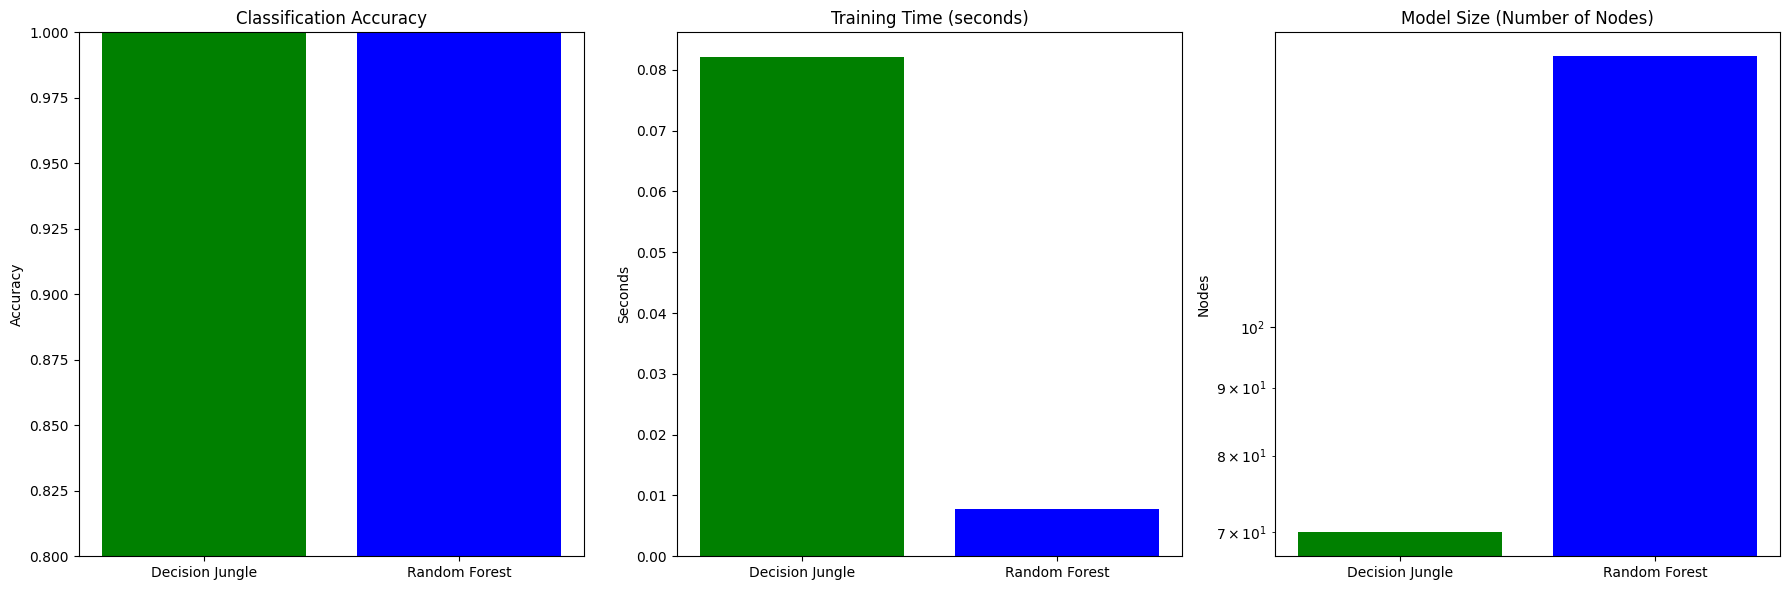

In [20]:
# Visualize the comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Accuracy
axes[0].bar(['Decision Jungle', 'Random Forest'], 
        [jungle_accuracy, forest_accuracy],
        color=['green', 'blue'])
axes[0].set_title('Classification Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim(0.8, 1.0)  # Adjust as needed

# Plot 2: Training Time
axes[1].bar(['Decision Jungle', 'Random Forest'], 
        [jungle_train_time, forest_train_time],
        color=['green', 'blue'])
axes[1].set_title('Training Time (seconds)')
axes[1].set_ylabel('Seconds')

# Plot 3: Model Size (Number of Nodes)
axes[2].bar(['Decision Jungle', 'Random Forest'], 
        [jungle.get_node_count(), forest_nodes],
        color=['green', 'blue'])
axes[2].set_title('Model Size (Number of Nodes)')
axes[2].set_ylabel('Nodes')
axes[2].set_yscale('log')

plt.tight_layout()
plt.savefig('notebook_visualizations/jungle_vs_forest.png')
plt.show()

<a id="tuning"></a>
## 4. Hyperparameter Tuning with Cross-Validation

Decision Jungles have multiple hyperparameters that can be tuned to achieve the best performance. Let's use scikit-learn's GridSearchCV to find optimal hyperparameters.

In [21]:
# For demonstration, we'll use a smaller parameter grid
param_grid = {
    'n_estimators': [5, 10],
    'max_width': [32, 64],
    'max_depth': [5, 10],
    'merging_schedule': ['constant', 'exponential']
}

# Create a Decision Jungle classifier
jungle = DecisionJungleClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=jungle,
    param_grid=param_grid,
    cv=5,                  # 5-fold cross-validation
    scoring='accuracy',    # Metric to optimize
    n_jobs=-1,             # Use all available cores
    verbose=1
)

# Fit the grid search
print("Running grid search (this may take a while)...")
grid_search.fit(X, y)  # Use the entire Iris dataset for this example

# Print results
print("\nGrid Search Results:")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

Running grid search (this may take a while)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Grid Search Results:
Best parameters: {'max_depth': 5, 'max_width': 32, 'merging_schedule': 'exponential', 'n_estimators': 5}
Best cross-validation score: 0.9333


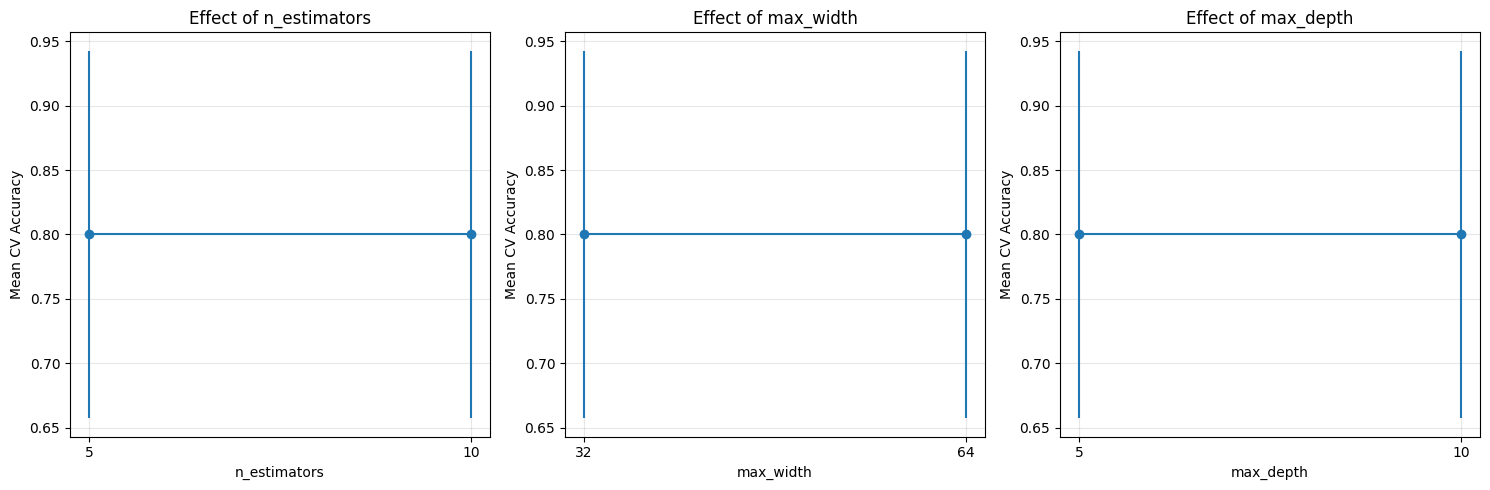

In [22]:
# Analyze grid search results
results = pd.DataFrame(grid_search.cv_results_)

# Parameters to analyze
params_to_analyze = ['param_n_estimators', 'param_max_width', 'param_max_depth']

# Create plots for each parameter
fig, axes = plt.subplots(1, len(params_to_analyze), figsize=(15, 5))

for i, param in enumerate(params_to_analyze):
    # Get unique values of the parameter
    unique_values = results[param].unique()
    unique_values = [str(val) for val in unique_values]
    
    # Calculate mean scores for each value
    mean_scores = []
    std_scores = []
    
    for val in unique_values:
        # Filter results for this parameter value
        param_results = results[results[param].astype(str) == val]
        mean_scores.append(param_results['mean_test_score'].mean())
        std_scores.append(param_results['mean_test_score'].std())
    
    # Plot
    axes[i].errorbar(unique_values, mean_scores, yerr=std_scores, fmt='o-')
    axes[i].set_xlabel(param.replace('param_', ''))
    axes[i].set_ylabel('Mean CV Accuracy')
    axes[i].set_title(f'Effect of {param.replace("param_", "")}')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('notebook_visualizations/grid_search_params_analysis.png')
plt.show()

### Randomized Search CV

For larger parameter spaces, RandomizedSearchCV can be more efficient.

In [23]:
# Define the parameter distributions
param_dist = {
    'n_estimators': randint(5, 15),
    'max_width': randint(16, 128),
    'max_depth': randint(3, 15),
    'merging_schedule': ['constant', 'exponential', 'kinect'],
    'min_samples_split': randint(2, 10),
    'max_features': ['sqrt', 'log2', None, 0.5]
}

# Create a Decision Jungle classifier
jungle = DecisionJungleClassifier(random_state=42)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=jungle,
    param_distributions=param_dist,
    n_iter=10,  # Number of parameter settings to sample
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Fit the random search
print("Running randomized search...")
random_search.fit(X, y)

# Print results
print("\nRandomized Search Results:")
print(f"Best parameters: {random_search.best_params_}")
print(f"Best cross-validation score: {random_search.best_score_:.4f}")

Running randomized search...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Randomized Search Results:
Best parameters: {'max_depth': 9, 'max_features': 0.5, 'max_width': 108, 'merging_schedule': 'kinect', 'min_samples_split': 4, 'n_estimators': 12}
Best cross-validation score: 0.9600


<a id="pipelines"></a>
## 5. Integration with scikit-learn Pipelines

Decision Jungles can be integrated into scikit-learn's Pipeline API for end-to-end machine learning workflows.

In [24]:
# Load a more complex dataset
wine = load_wine()
X, y = wine.data, wine.target

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Create a pipeline with preprocessing and a Decision Jungle classifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('jungle', DecisionJungleClassifier(
        n_estimators=10,
        max_width=64,
        max_depth=10,
        random_state=42
    ))
])

# Train the pipeline
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Pipeline accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=wine.target_names))

Pipeline accuracy: 0.9444

Classification Report:
              precision    recall  f1-score   support

     class_0       0.90      1.00      0.95        19
     class_1       0.95      0.90      0.93        21
     class_2       1.00      0.93      0.96        14

    accuracy                           0.94        54
   macro avg       0.95      0.94      0.95        54
weighted avg       0.95      0.94      0.94        54



### Pipeline with Feature Selection

Let's add feature selection to the pipeline.

In [25]:
# Create a pipeline with feature selection
pipeline_with_selection = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(f_classif, k=5)),  # Select top 5 features
    ('jungle', DecisionJungleClassifier(
        n_estimators=10,
        max_width=64,
        random_state=42
    ))
])

# Train the pipeline
pipeline_with_selection.fit(X_train, y_train)

# Make predictions
y_pred = pipeline_with_selection.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# Get the selected features
selected_indices = pipeline_with_selection.named_steps['feature_selection'].get_support(indices=True)
selected_features = [wine.feature_names[i] for i in selected_indices]

print(f"Pipeline with feature selection accuracy: {accuracy:.4f}")
print("\nSelected Features:")
for i, feature in enumerate(selected_features):
    print(f"{i+1}. {feature}")

# Get memory usage
jungle_with_selection = pipeline_with_selection.named_steps['jungle']
print(f"\nMemory usage with feature selection: {jungle_with_selection.get_memory_usage()} bytes")

Pipeline with feature selection accuracy: 0.9074

Selected Features:
1. alcohol
2. flavanoids
3. color_intensity
4. od280/od315_of_diluted_wines
5. proline

Memory usage with feature selection: 4480 bytes


### Cross-validation with Pipelines

In [26]:
# Perform cross-validation on the pipeline
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Cross-validation scores: [0.91666667 0.88888889 0.94444444 0.97142857 1.        ]
Mean CV accuracy: 0.9443 ± 0.0392


### Pipeline Grid Search

We can perform grid search on the entire pipeline, tuning both preprocessing and model parameters.

In [27]:
# Create a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(f_classif)),
    ('jungle', DecisionJungleClassifier(random_state=42))
])

# Define a simpler parameter grid for the sake of runtime
param_grid = {
    'feature_selection__k': [5, 8, 10],
    'jungle__n_estimators': [5, 10],
    'jungle__max_width': [32, 64],
    'jungle__merging_schedule': ['constant', 'exponential']
}

# Set up GridSearchCV on the pipeline
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,  # Reduced CV for runtime
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit the grid search
print("Running grid search on pipeline...")
grid_search.fit(X, y)

# Print results
print("\nPipeline Grid Search Results:")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

Running grid search on pipeline...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Pipeline Grid Search Results:
Best parameters: {'feature_selection__k': 8, 'jungle__max_width': 32, 'jungle__merging_schedule': 'exponential', 'jungle__n_estimators': 5}
Best cross-validation score: 0.9162


<a id="visualization"></a>
## 6. Advanced Visualization

Let's visualize a Decision Jungle's internal structure.

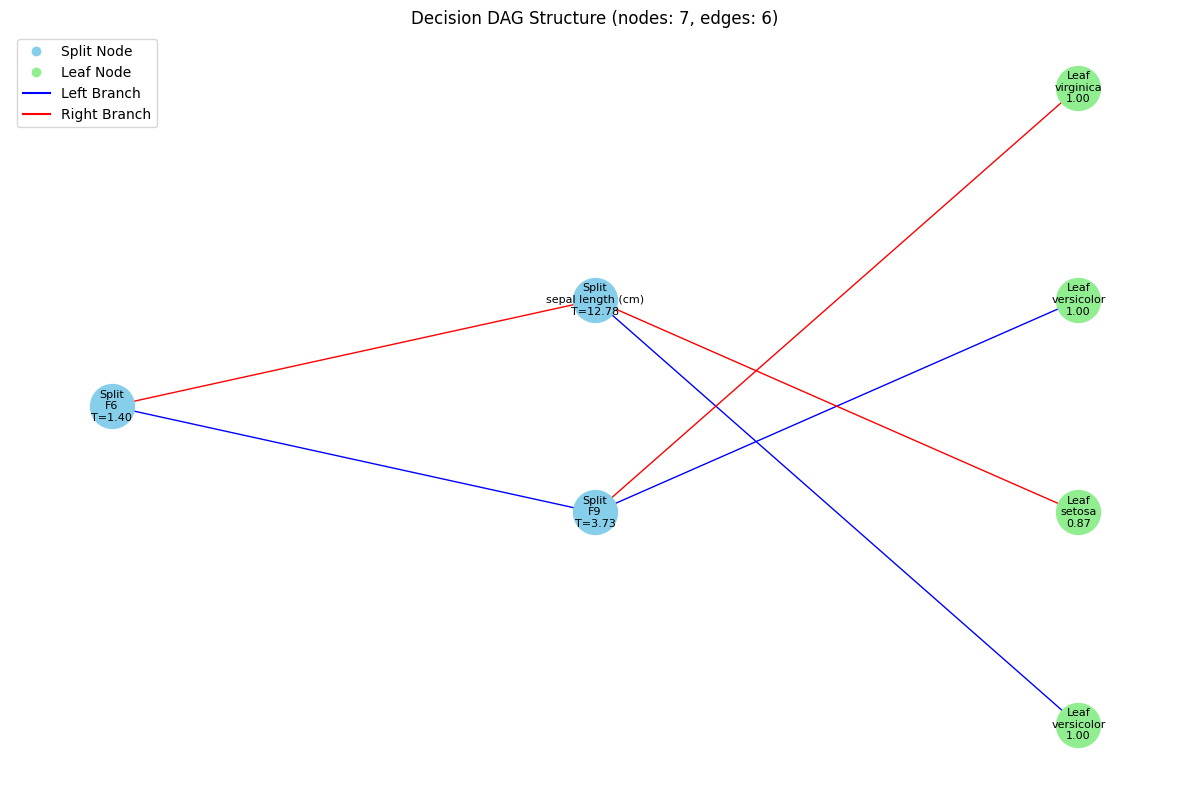

In [28]:
# Create a simple jungle for visualization
simple_jungle = DecisionJungleClassifier(
    n_estimators=1,  # Just one DAG for visualization
    max_width=6,     # Small width for better visualization
    max_depth=3,     # Limited depth for better visualization
    random_state=42
)

# Train on Iris data
simple_jungle.fit(X_train, y_train)

# Get the single DAG
dag = simple_jungle.dags_[0]

# Visualize the DAG structure
fig = plot_dag(
    dag, 
    feature_names=iris.feature_names,
    class_names=iris.target_names,
    max_depth=3,
    figsize=(12, 8),
    node_size=1000,
    font_size=8
)

plt.savefig('notebook_visualizations/dag_visualization.png')
plt.show()

### Comparing Merging Schedules

The merging schedule controls how the width constraint changes with depth.

Training jungle with constant merging schedule...
Training jungle with exponential merging schedule...
Training jungle with kinect merging schedule...


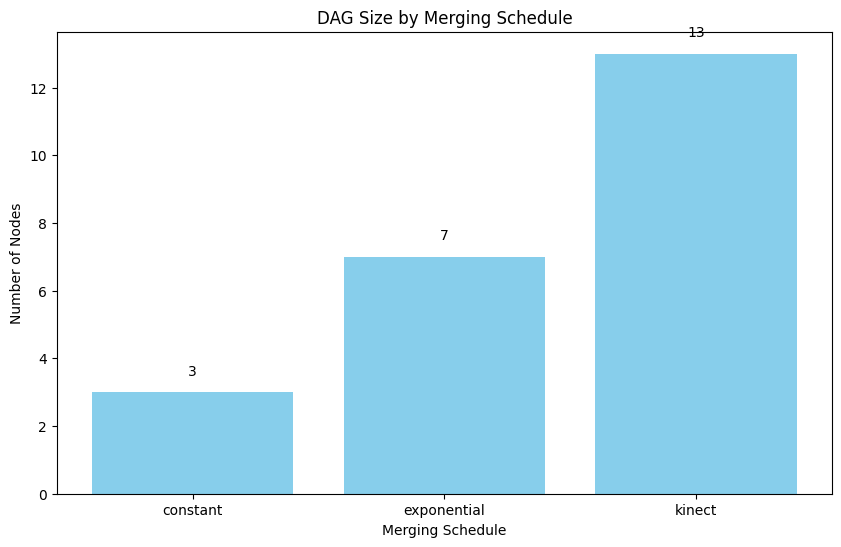

In [29]:
# Create and train jungles with different merging schedules
merging_schedules = ['constant', 'exponential', 'kinect']
jungles = {}

for schedule in merging_schedules:
    print(f"Training jungle with {schedule} merging schedule...")
    jungle = DecisionJungleClassifier(
        n_estimators=1,
        max_width=6,
        max_depth=3,
        merging_schedule=schedule,
        random_state=42
    )
    
    jungle.fit(X_train, y_train)
    jungles[schedule] = jungle

# Compare node counts
node_counts = {schedule: jungles[schedule].dags_[0].get_node_count() 
               for schedule in merging_schedules}

# Create a bar chart for node counts
plt.figure(figsize=(10, 6))
plt.bar(node_counts.keys(), node_counts.values(), color='skyblue')
plt.title('DAG Size by Merging Schedule')
plt.xlabel('Merging Schedule')
plt.ylabel('Number of Nodes')

# Add value labels on the bars
for schedule, count in node_counts.items():
    plt.text(schedule, count + 0.5, str(count), ha='center')

plt.savefig('notebook_visualizations/node_counts_by_schedule.png')
plt.show()

### Visualizing Decision Paths

Let's visualize the decision path for a specific sample.

In [30]:
# Select a specific sample
sample_idx = 5
sample = X_test[sample_idx]
true_class = y_test[sample_idx]

# Manually trace a path through the DAG
def trace_path(dag, sample):
    path = []
    current_node_id = dag.root_node_id
    path.append(current_node_id)
    
    # Traverse the DAG until we reach a leaf node
    while True:
        current_node = dag.nodes[current_node_id]
        
        # If we've reached a leaf node, we're done
        if not hasattr(current_node, 'feature_idx'):
            break
            
        # For split nodes, determine which child to go to
        feature_idx = current_node.feature_idx
        
        # Ensure feature_idx is valid for the sample
        if 0 <= feature_idx < len(sample):
            feature_value = sample[feature_idx]
            
            # Handle categorical features
            if hasattr(current_node, 'is_categorical') and current_node.is_categorical:
                if hasattr(current_node, 'categories_left') and current_node.categories_left:
                    if not np.isnan(feature_value) and feature_value in current_node.categories_left:
                        current_node_id = current_node.left_child
                    else:
                        current_node_id = current_node.right_child
                else:
                    current_node_id = current_node.right_child
            else:
                # Numerical feature
                if np.isnan(feature_value):
                    current_node_id = current_node.right_child
                elif feature_value <= current_node.threshold:
                    current_node_id = current_node.left_child
                else:
                    current_node_id = current_node.right_child
                    
            path.append(current_node_id)
        else:
            # If feature index is invalid, just break
            break
    
    return path

# Get the path for our sample
path = trace_path(dag, sample)
print(f"Decision path for sample {sample_idx}: {path}")

Decision path for sample 5: [0, 2, 4]


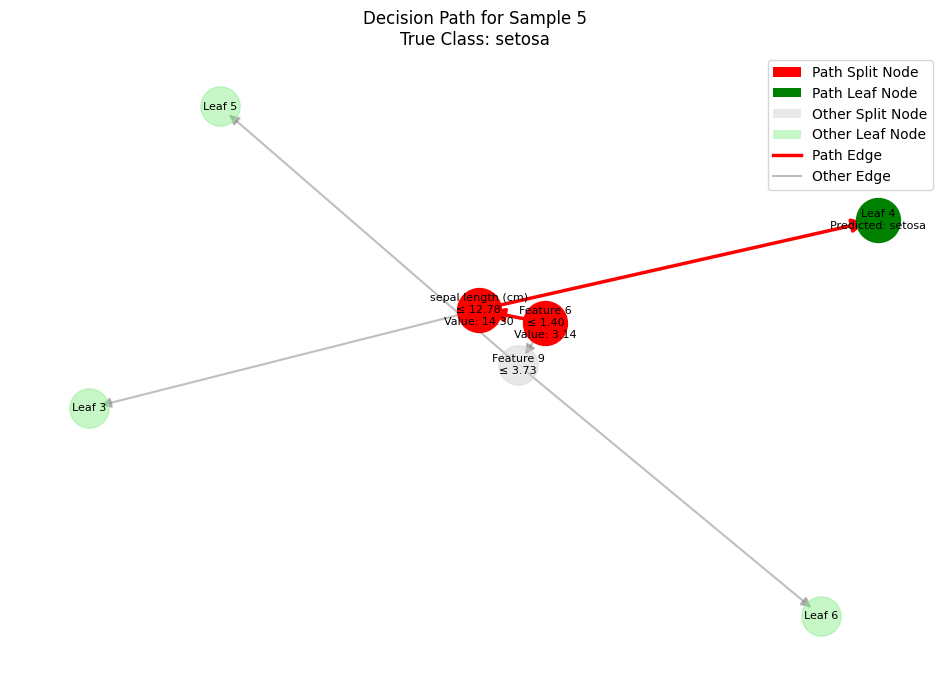

In [31]:
# Visualize the path through the DAG
plt.figure(figsize=(12, 8))
G = nx.DiGraph()

# Add nodes and edges to the graph
for node_id in dag.nodes:
    node = dag.nodes[node_id]
    if hasattr(node, 'feature_idx'):  # Split node
        G.add_node(node_id, type='split', feature=node.feature_idx, threshold=node.threshold)
    else:  # Leaf node
        G.add_node(node_id, type='leaf', distribution=node.class_distribution if hasattr(node, 'class_distribution') else None)

# Add edges
for node_id in dag.nodes:
    node = dag.nodes[node_id]
    if hasattr(node, 'feature_idx'):  # Split node has children
        G.add_edge(node_id, node.left_child, direction='left')
        G.add_edge(node_id, node.right_child, direction='right')

# Create a layout
pos = nx.spring_layout(G, seed=42)

# Separate path and non-path nodes for coloring
path_nodes = set(path)
non_path_nodes = set(G.nodes) - path_nodes

# Get path edges
path_edges = []
for i in range(len(path) - 1):
    path_edges.append((path[i], path[i+1]))

non_path_edges = [(u, v) for u, v in G.edges if (u, v) not in path_edges]

# Draw nodes
nx.draw_networkx_nodes(G, pos, 
                      nodelist=[n for n in non_path_nodes if G.nodes[n]['type'] == 'split'],
                      node_color='lightgray',
                      node_size=800,
                      alpha=0.5)

nx.draw_networkx_nodes(G, pos, 
                      nodelist=[n for n in non_path_nodes if G.nodes[n]['type'] == 'leaf'],
                      node_color='lightgreen',
                      node_size=800,
                      alpha=0.5)

nx.draw_networkx_nodes(G, pos, 
                      nodelist=[n for n in path_nodes if G.nodes[n]['type'] == 'split'],
                      node_color='red',
                      node_size=1000)

nx.draw_networkx_nodes(G, pos, 
                      nodelist=[n for n in path_nodes if G.nodes[n]['type'] == 'leaf'],
                      node_color='green',
                      node_size=1000)

# Draw edges
nx.draw_networkx_edges(G, pos, 
                      edgelist=non_path_edges,
                      edge_color='gray',
                      alpha=0.5,
                      width=1.5,
                      arrowsize=15)

nx.draw_networkx_edges(G, pos, 
                      edgelist=path_edges,
                      edge_color='red',
                      width=2.5,
                      arrowsize=20)

# Add node labels with safe feature access
labels = {}
for node in G.nodes:
    if G.nodes[node]['type'] == 'split':
        feature_idx = G.nodes[node]['feature']
        threshold = G.nodes[node]['threshold']
        
        # Safe feature name access
        if 0 <= feature_idx < len(iris.feature_names):
            feature_name = iris.feature_names[feature_idx]
        else:
            feature_name = f"Feature {feature_idx}"
        
        # Safe feature value access
        if 0 <= feature_idx < len(sample):
            feature_value = sample[feature_idx]
            # Add the feature value to the label if this node is in the path
            if node in path_nodes:
                labels[node] = f"{feature_name}\n≤ {threshold:.2f}\nValue: {feature_value:.2f}"
            else:
                labels[node] = f"{feature_name}\n≤ {threshold:.2f}"
        else:
            # Fallback when feature index is out of bounds
            labels[node] = f"{feature_name}\n≤ {threshold:.2f}"
    else:
        # For leaf nodes, show the class distribution
        if node in path_nodes and G.nodes[node]['distribution'] is not None:
            class_dist = G.nodes[node]['distribution']
            if len(class_dist) > 0:
                pred_class = np.argmax(class_dist)
                # Safe class name access
                if 0 <= pred_class < len(iris.target_names):
                    labels[node] = f"Leaf {node}\nPredicted: {iris.target_names[pred_class]}"
                else:
                    labels[node] = f"Leaf {node}\nPredicted: Class {pred_class}"
            else:
                labels[node] = f"Leaf {node}"
        else:
            labels[node] = f"Leaf {node}"

nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)

# Add title and legend
class_name = iris.target_names[true_class] if 0 <= true_class < len(iris.target_names) else f"Class {true_class}"
plt.title(f"Decision Path for Sample {sample_idx}\nTrue Class: {class_name}")

# Create legend
legend_elements = [
    Patch(facecolor='red', label='Path Split Node'),
    Patch(facecolor='green', label='Path Leaf Node'),
    Patch(facecolor='lightgray', alpha=0.5, label='Other Split Node'),
    Patch(facecolor='lightgreen', alpha=0.5, label='Other Leaf Node'),
    Line2D([0], [0], color='red', lw=2.5, label='Path Edge'),
    Line2D([0], [0], color='gray', lw=1.5, alpha=0.5, label='Other Edge')
]

plt.legend(handles=legend_elements, loc='upper right')
plt.axis('off')
plt.savefig('notebook_visualizations/decision_path.png')
plt.show()

<a id="feature-importance"></a>
## 7. Feature Importance

Let's analyze feature importance by checking how often each feature is used in the Decision Jungle.

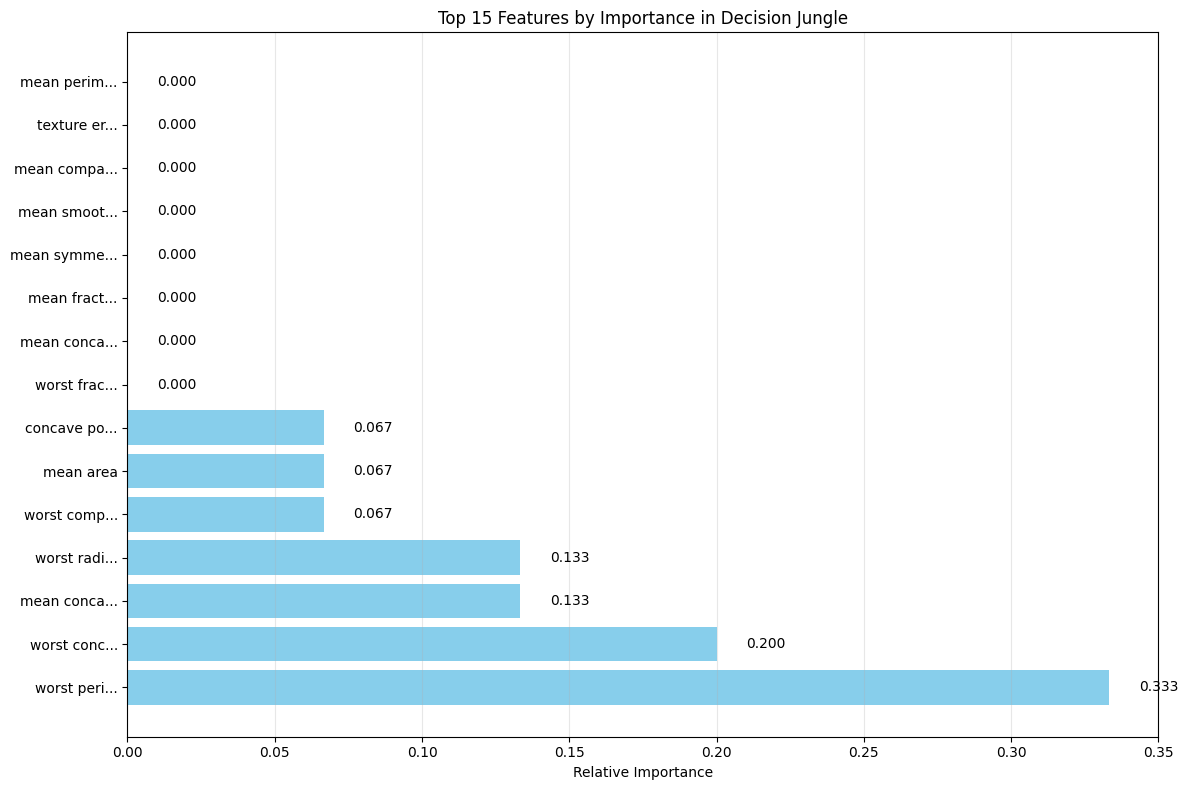

In [32]:
# Load Breast Cancer dataset for more features
cancer = load_breast_cancer()
X, y = cancer.data, cancer.target

# Create shortened feature names
feature_names = [name[:10] + '...' if len(name) > 10 else name 
                 for name in cancer.feature_names]

# Create and train a Decision Jungle with multiple estimators
feature_jungle = DecisionJungleClassifier(
    n_estimators=5,
    max_width=16,
    max_depth=6,
    random_state=42
)

feature_jungle.fit(X, y)

# Count feature usage across all DAGs
feature_counts = np.zeros(X.shape[1])

for dag in feature_jungle.dags_:
    for node_id in dag.nodes:
        node = dag.nodes[node_id]
        if hasattr(node, 'feature_idx'):  # Split node
            feature_counts[node.feature_idx] += 1

# Calculate normalized importance
total_splits = np.sum(feature_counts)
feature_importance = feature_counts / total_splits if total_splits > 0 else feature_counts

# Sort by importance
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_importance = feature_importance[sorted_indices]
sorted_names = [feature_names[i] for i in sorted_indices]

# Plot top 15 features for clarity
plt.figure(figsize=(12, 8))
plt.barh(range(15), sorted_importance[:15], color='skyblue')
plt.yticks(range(15), sorted_names[:15])
plt.xlabel('Relative Importance')
plt.title('Top 15 Features by Importance in Decision Jungle')
plt.grid(True, axis='x', alpha=0.3)

# Add value labels
for i, v in enumerate(sorted_importance[:15]):
    plt.text(v + 0.01, i, f'{v:.3f}', va='center')

plt.tight_layout()
plt.savefig('notebook_visualizations/feature_importance.png')
plt.show()

<a id="memory"></a>
## 8. Memory Efficiency

One of the key advantages of Decision Jungles is their memory efficiency. Let's compare memory usage across different models and datasets.

In [33]:
# Function to compare memory usage across datasets
def compare_memory_across_datasets(n_estimators=10, max_depth=10, max_width=64):
    datasets = {
        'Iris': load_iris(),
        'Wine': load_wine(),
        'Breast Cancer': load_breast_cancer()
    }
    
    results = []
    
    for name, dataset in datasets.items():
        X, y = dataset.data, dataset.target
        
        # Train Decision Jungle
        jungle = DecisionJungleClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            max_width=max_width,
            random_state=42
        )
        jungle.fit(X, y)
        
        # Train Random Forest
        forest = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            random_state=42
        )
        forest.fit(X, y)
        
        # Get node counts
        jungle_nodes = jungle.get_node_count()
        forest_nodes = sum(tree.tree_.node_count for tree in forest.estimators_)
        
        # Get memory comparison
        memory_comparison = compare_memory_usage(jungle, forest)
        
        results.append({
            'dataset': name,
            'features': X.shape[1],
            'classes': len(np.unique(y)),
            'jungle_nodes': jungle_nodes,
            'forest_nodes': forest_nodes,
            'memory_ratio': memory_comparison['memory_ratio']
        })
    
    return results

# Run the comparison
memory_results = compare_memory_across_datasets()

# Convert to DataFrame for better display
results_df = pd.DataFrame(memory_results)
results_df

,dataset,features,classes,jungle_nodes,forest_nodes,memory_ratio
0,Iris,4,3,70,158,0.107143
1,Wine,13,3,70,208,0.107143
2,Breast Cancer,30,2,70,390,0.115385


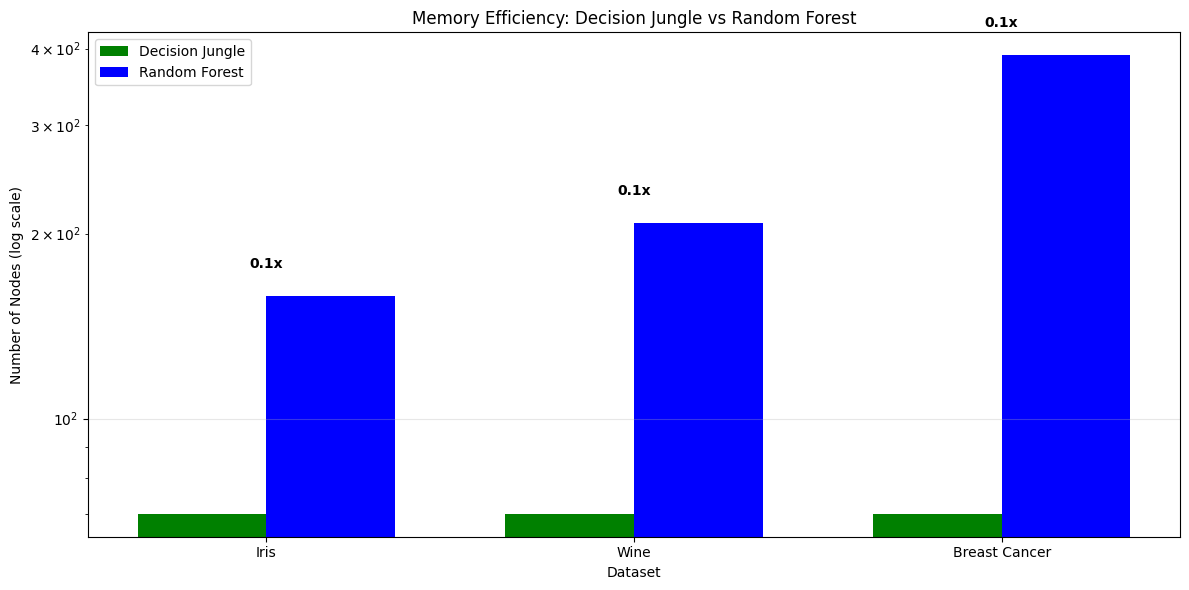

In [34]:
# Visualize the memory comparison
plt.figure(figsize=(12, 6))

# Create bar positions
datasets = results_df['dataset']
x = np.arange(len(datasets))
width = 0.35

# Plot bars
plt.bar(x - width/2, results_df['jungle_nodes'], width, label='Decision Jungle', color='green')
plt.bar(x + width/2, results_df['forest_nodes'], width, label='Random Forest', color='blue')

# Customize plot
plt.xlabel('Dataset')
plt.ylabel('Number of Nodes (log scale)')
plt.title('Memory Efficiency: Decision Jungle vs Random Forest')
plt.xticks(x, datasets)
plt.yscale('log')
plt.legend()
plt.grid(True, axis='y', alpha=0.3)

# Add memory ratio annotations
for i, ratio in enumerate(results_df['memory_ratio']):
    plt.text(i, results_df['forest_nodes'][i] * 1.1, f'{ratio:.1f}x', 
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('notebook_visualizations/memory_comparison.png')
plt.show()

### Memory vs. Width Parameter

The max_width parameter directly controls the memory-accuracy trade-off in Decision Jungles.

In [35]:
# Compare memory usage across different width values
width_values = [8, 16, 32, 64, 128, 256]
width_results = []

# Use breast cancer dataset
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

for width in width_values:
    # Train Decision Jungle
    jungle = DecisionJungleClassifier(
        n_estimators=5,
        max_depth=8,
        max_width=width,
        random_state=42
    )
    jungle.fit(X_train, y_train)
    
    # Evaluate
    accuracy = jungle.score(X_test, y_test)
    nodes = jungle.get_node_count()
    
    width_results.append({
        'max_width': width,
        'accuracy': accuracy,
        'nodes': nodes
    })

# Convert to DataFrame
width_df = pd.DataFrame(width_results)
width_df

,max_width,accuracy,nodes
0,8,0.935673,35
1,16,0.935673,35
2,32,0.935673,35
3,64,0.935673,35
4,128,0.935673,35
5,256,0.935673,35


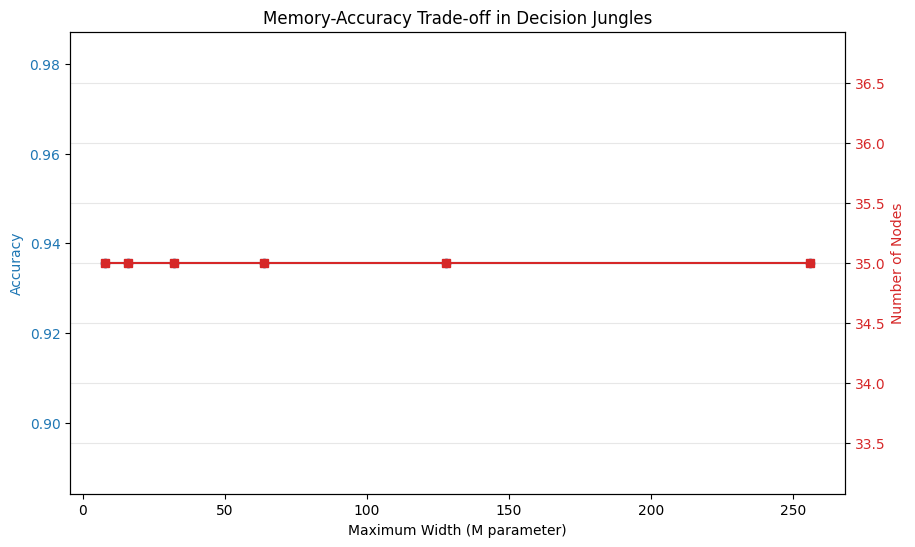

In [36]:
# Plot the memory-accuracy trade-off
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot accuracy
color = 'tab:blue'
ax1.set_xlabel('Maximum Width (M parameter)')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(width_df['max_width'], width_df['accuracy'], 'o-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create second y-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Number of Nodes', color=color)
ax2.plot(width_df['max_width'], width_df['nodes'], 's-', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Memory-Accuracy Trade-off in Decision Jungles')
plt.grid(True, alpha=0.3)
plt.savefig('notebook_visualizations/memory_accuracy_tradeoff.png')
plt.show()

## Conclusion

In this notebook, we've explored the key features and capabilities of Decision Jungles:

1. **Memory efficiency**: Decision Jungles achieve significant memory savings compared to Random Forests by allowing nodes to have multiple parents.

2. **Comparable accuracy**: Despite using fewer nodes, Decision Jungles typically maintain similar accuracy to Random Forests.

3. **Flexible trade-offs**: The max_width parameter allows fine-tuning the memory-accuracy trade-off.

4. **Integration with scikit-learn**: Decision Jungles work seamlessly with scikit-learn's pipelines, cross-validation, and grid search.

5. **Advanced visualization**: The internal structure of Decision Jungles can be visualized to gain insights into the model's decision-making process.

Decision Jungles are particularly valuable in memory-constrained environments, such as embedded systems or mobile devices, where model size is a significant concern.